# Monte Carlo Dropout Bayesian Neural Network 

*This implementation provides **uncertainty quantification** using **Monte Carlo Dropout** instead of variational inference, ensuring compatibility across TensorFlow versions*


**Link**: Dropout as Bayesian Approximation (Gal & Ghahramani, 2016): https://proceedings.mlr.press/v48/gal16.pdf*


---

## Steps (in Keywords)

1. **Imports & Setup**
   - Load required libraries (`pandas`, `numpy`, `matplotlib`, `seaborn`, `sklearn`, `scipy`, `tensorflow`)
   - Suppress warnings
   - Print TensorFlow version

2. **MC Dropout Bayesian Neural Network Class**
   - `__init__`: Define input/output dimensions, hidden layers, dropout rate
   - `build_model`: Construct network (Dense + Dropout layers, output layer)
   - `compile_model`: Compile with Adam optimizer, MSE loss, MAE metric
   - `fit`: Train model with validation split
   - `predict_with_uncertainty`: Perform Monte Carlo sampling (`training=True`) → mean & std predictions

3. **Data Loading & Preprocessing**
   - Load **Band Fluence dataset** from GitHub
   - Select features: `T90`, `Ep`, `Sbolo`, `Alpha`, `Beta`
   - Apply **log10 transformation** (for scale correction)
   - Prepare features `X` and target `y` (`Redshift`)

4. **Main Execution (`main`)**
   - Load and preprocess dataset
   - Train/test split (70/30)
   - Standardize features (`StandardScaler`)
   - Define **ensemble architectures**:
     - `[64, 32]`
     - `[128, 64, 32]`
     - `[96, 48, 24]`
   - Train models sequentially
   - Predict with uncertainty (Monte Carlo sampling)

5. **Ensemble Predictions & Uncertainty**
   - Average predictions across ensemble
   - Compute **Epistemic uncertainty** (std across models)
   - Compute **Aleatoric uncertainty** (mean of per-model uncertainty)
   - Combine uncertainties → **Total uncertainty**

6. **Model Evaluation**
   - Metrics: R², RMSE, MAE (train & test sets)
   - Print mean uncertainties (epistemic, aleatoric, total)

7. **Results Storage**
   - Store predictions + uncertainties in DataFrames
   - Train & Test results saved

8. **Visualization**
   - Scatter plots (True vs Predicted with uncertainty colorbar)
   - Uncertainty decomposition (Epistemic vs Aleatoric)
   - Uncertainty vs Prediction Error
   - Save plots as `MC_Dropout_BNN_Results.png`

9. **Apply to Extended Dataset**
   - Load extended dataset (`kw_band_flc_flx.xlsx`)
   - Filter: `T90 >= 2.1`, `Beta <= -2`
   - Preprocess (log10 transform, scaling)
   - Predict pseudo-redshifts + uncertainties
   - Save results → `mc_dropout_pseudo_redshift_bandflc.csv`

10. **Execution Block**
    - Set random seeds (`numpy`, `tensorflow`)
    - Run `main()`
    - Print output messages & saved files

---

## Outputs
- **Figures:** `MC_Dropout_BNN_Results.png`  
- **CSV file:** `mc_dropout_pseudo_redshift_bandflc.csv`  
- Ensemble predictions with **Bayesian uncertainty quantification**  


TensorFlow version: 2.19.0
Starting MC Dropout Bayesian Neural Network analysis...
Loading data...
Dataset size: 56 samples

Training MC Dropout Bayesian ensemble...

Training model 1/3 with architecture: [64, 32]
Model 1 training completed

Training model 2/3 with architecture: [128, 64, 32]
Model 2 training completed

Training model 3/3 with architecture: [96, 48, 24]
Model 3 training completed

Making predictions with uncertainty quantification...
Getting predictions from model 1
Getting predictions from model 2
Getting predictions from model 3

MC DROPOUT BAYESIAN NEURAL NETWORK RESULTS
Training - R²: 0.826, RMSE: 0.739, MAE: 0.416
Training - Mean Total Uncertainty: 0.561
Training - Mean Epistemic Uncertainty: 0.289
Test - R²: -0.606, RMSE: 2.107, MAE: 1.773
Test - Mean Total Uncertainty: 0.728
Test - Mean Epistemic Uncertainty: 0.492


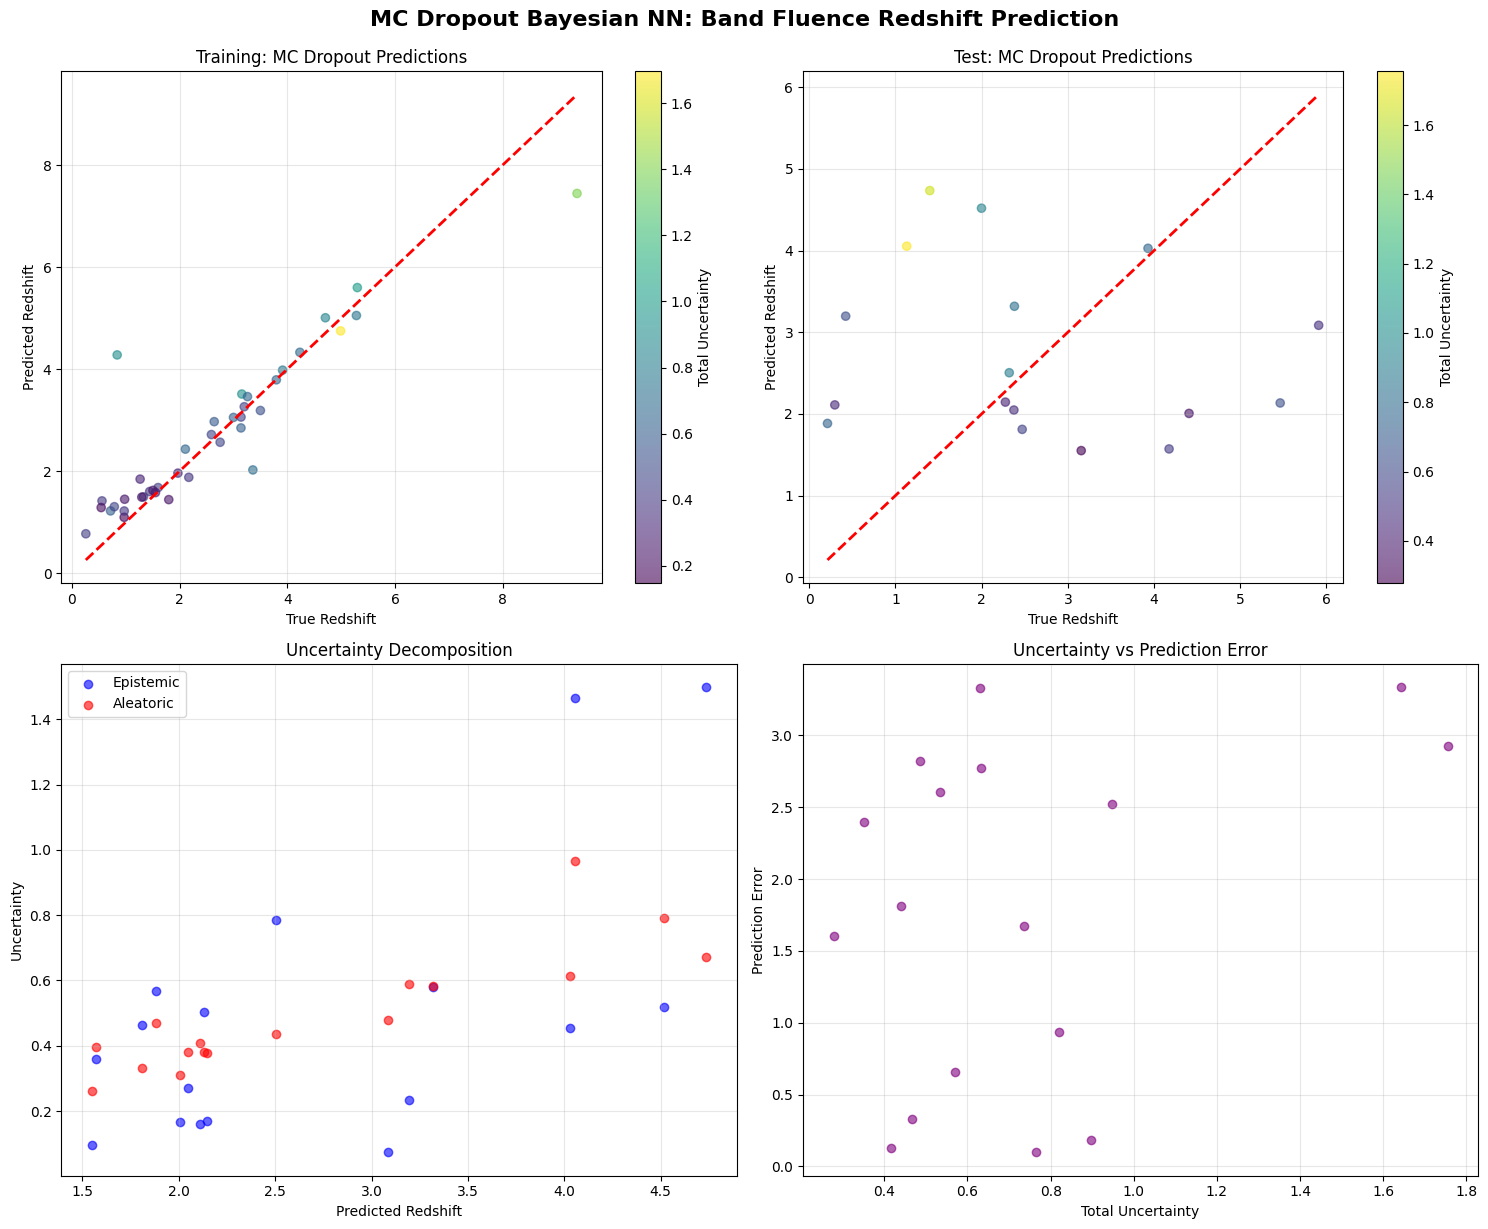


Applying to extended dataset...
Extended dataset size: 78
Pseudo-redshift range: 0.546 - 7.470
Mean total uncertainty: 0.601

Analysis completed successfully!
Files saved:
- MC_Dropout_BNN_Results.png
- mc_dropout_pseudo_redshift_bandflc.csv


In [2]:
"""Monte Carlo Dropout Bayesian Neural Network - Alternative Implementation

This provides uncertainty quantification using Monte Carlo Dropout instead of 
variational inference, which is more compatible across TensorFlow versions.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# ============================================================================
# MONTE CARLO DROPOUT BAYESIAN NEURAL NETWORK
# ============================================================================

class MCDropoutBayesianNN:
    """Monte Carlo Dropout for Bayesian Neural Networks"""
    
    def __init__(self, input_dim, hidden_units, dropout_rate=0.1, output_dim=1):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.output_dim = output_dim
        self.model = None
        
    def build_model(self):
        """Build the MC Dropout model"""
        model = keras.Sequential([
            keras.layers.InputLayer(input_shape=(self.input_dim,))
        ])
        
        # Add hidden layers with dropout
        for units in self.hidden_units:
            model.add(keras.layers.Dense(units, activation='relu'))
            model.add(keras.layers.Dropout(self.dropout_rate))
        
        # Output layer
        model.add(keras.layers.Dense(self.output_dim))
        
        self.model = model
        return model
    
    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='mse',
            metrics=['mae']
        )
    
    def fit(self, X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=1):
        """Train the model"""
        history = self.model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=verbose
        )
        return history
    
    def predict_with_uncertainty(self, X, n_samples=100):
        """Predict with uncertainty using Monte Carlo sampling"""
        predictions = []
        
        # Enable dropout during prediction
        for _ in range(n_samples):
            pred = self.model(X, training=True)  # Keep dropout active
            predictions.append(pred.numpy())
        
        predictions = np.array(predictions)
        
        # Calculate statistics
        mean_pred = np.mean(predictions, axis=0).flatten()
        std_pred = np.std(predictions, axis=0).flatten()
        
        return mean_pred, std_pred

def load_and_preprocess_data():
    """Load and preprocess the Band Fluence dataset"""
    url = 'https://raw.githubusercontent.com/Adrita-Khan/GRB-ML/main/Data/kw_band_flc.xlsx'
    GBM_df = pd.read_excel(url)
    
    # Extract relevant columns
    columns = ['Redshift', 'T90', 'Alpha', 'Beta', 'Ep', 'Sbolo']
    GBM_df = GBM_df[columns]
    
    # Apply log transformation
    log_data = np.log10(GBM_df[['T90', 'Ep', 'Sbolo']])
    
    # Add spectral indices
    log_data['Alpha_flc'] = GBM_df['Alpha']
    log_data['Beta_flc'] = GBM_df['Beta']
    
    # Prepare features and target
    X = log_data
    y = GBM_df['Redshift']
    
    return X, y

def main():
    """Main execution function"""
    
    # Load data
    print("Loading data...")
    X, y = load_and_preprocess_data()
    print(f"Dataset size: {len(y)} samples")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create ensemble of MC Dropout models
    models = []
    model_configs = [
        [64, 32],
        [128, 64, 32],
        [96, 48, 24]
    ]
    
    print("\nTraining MC Dropout Bayesian ensemble...")
    
    for i, hidden_units in enumerate(model_configs):
        print(f"\nTraining model {i+1}/{len(model_configs)} with architecture: {hidden_units}")
        
        # Create and train model
        mc_model = MCDropoutBayesianNN(
            input_dim=X_train_scaled.shape[1],
            hidden_units=hidden_units,
            dropout_rate=0.1
        )
        
        mc_model.build_model()
        mc_model.compile_model(learning_rate=0.01)
        
        # Train model
        history = mc_model.fit(
            X_train_scaled, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.1,
            verbose=0
        )
        
        models.append(mc_model)
        print(f"Model {i+1} training completed")
    
    # Make predictions with uncertainty
    print("\nMaking predictions with uncertainty quantification...")
    
    # Ensemble predictions
    ensemble_train_preds = []
    ensemble_test_preds = []
    ensemble_train_uncertainties = []
    ensemble_test_uncertainties = []
    
    for i, model in enumerate(models):
        print(f"Getting predictions from model {i+1}")
        
        # Training predictions
        train_pred, train_uncertainty = model.predict_with_uncertainty(
            X_train_scaled, n_samples=50
        )
        
        # Test predictions  
        test_pred, test_uncertainty = model.predict_with_uncertainty(
            X_test_scaled, n_samples=50
        )
        
        ensemble_train_preds.append(train_pred)
        ensemble_test_preds.append(test_pred)
        ensemble_train_uncertainties.append(train_uncertainty)
        ensemble_test_uncertainties.append(test_uncertainty)
    
    # Average ensemble predictions
    final_train_pred = np.mean(ensemble_train_preds, axis=0)
    final_test_pred = np.mean(ensemble_test_preds, axis=0)
    
    # Combine uncertainties (epistemic + aleatoric)
    epistemic_train_unc = np.std(ensemble_train_preds, axis=0)
    aleatoric_train_unc = np.mean(ensemble_train_uncertainties, axis=0)
    total_train_unc = np.sqrt(epistemic_train_unc**2 + aleatoric_train_unc**2)
    
    epistemic_test_unc = np.std(ensemble_test_preds, axis=0)
    aleatoric_test_unc = np.mean(ensemble_test_uncertainties, axis=0)
    total_test_unc = np.sqrt(epistemic_test_unc**2 + aleatoric_test_unc**2)
    
    # Evaluate performance
    print("\n" + "="*50)
    print("MC DROPOUT BAYESIAN NEURAL NETWORK RESULTS")
    print("="*50)
    
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, final_train_pred))
    train_mae = mean_absolute_error(y_train, final_train_pred)
    train_r2 = r2_score(y_train, final_train_pred)
    
    print(f"Training - R²: {train_r2:.3f}, RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}")
    print(f"Training - Mean Total Uncertainty: {np.mean(total_train_unc):.3f}")
    print(f"Training - Mean Epistemic Uncertainty: {np.mean(epistemic_train_unc):.3f}")
    
    # Test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, final_test_pred))
    test_mae = mean_absolute_error(y_test, final_test_pred)
    test_r2 = r2_score(y_test, final_test_pred)
    
    print(f"Test - R²: {test_r2:.3f}, RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}")
    print(f"Test - Mean Total Uncertainty: {np.mean(total_test_unc):.3f}")
    print(f"Test - Mean Epistemic Uncertainty: {np.mean(epistemic_test_unc):.3f}")
    
    # Create results dataframes
    train_results = pd.DataFrame({
        'Actual': y_train.values,
        'Predicted': final_train_pred,
        'Total_Uncertainty': total_train_unc,
        'Epistemic_Uncertainty': epistemic_train_unc,
        'Aleatoric_Uncertainty': aleatoric_train_unc
    })
    
    test_results = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': final_test_pred,
        'Total_Uncertainty': total_test_unc,
        'Epistemic_Uncertainty': epistemic_test_unc,
        'Aleatoric_Uncertainty': aleatoric_test_unc
    })
    
    # Plot results
    plot_results(train_results, test_results)
    
    # Apply to new data
    print("\nApplying to extended dataset...")
    try:
        apply_to_new_data(models, scaler)
    except Exception as e:
        print(f"Error applying to new data: {e}")
    
    return models, train_results, test_results

def plot_results(train_df, test_df):
    """Plot prediction results with uncertainty"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Training predictions with uncertainty
    scatter1 = axes[0,0].scatter(train_df['Actual'], train_df['Predicted'], 
                               c=train_df['Total_Uncertainty'], cmap='viridis', alpha=0.6)
    axes[0,0].plot([train_df['Actual'].min(), train_df['Actual'].max()], 
                  [train_df['Actual'].min(), train_df['Actual'].max()], 'r--', lw=2)
    axes[0,0].set_xlabel('True Redshift')
    axes[0,0].set_ylabel('Predicted Redshift')
    axes[0,0].set_title('Training: MC Dropout Predictions')
    axes[0,0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0,0], label='Total Uncertainty')
    
    # Test predictions with uncertainty
    scatter2 = axes[0,1].scatter(test_df['Actual'], test_df['Predicted'], 
                               c=test_df['Total_Uncertainty'], cmap='viridis', alpha=0.6)
    axes[0,1].plot([test_df['Actual'].min(), test_df['Actual'].max()], 
                  [test_df['Actual'].min(), test_df['Actual'].max()], 'r--', lw=2)
    axes[0,1].set_xlabel('True Redshift')
    axes[0,1].set_ylabel('Predicted Redshift')
    axes[0,1].set_title('Test: MC Dropout Predictions')
    axes[0,1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0,1], label='Total Uncertainty')
    
    # Uncertainty decomposition
    axes[1,0].scatter(test_df['Predicted'], test_df['Epistemic_Uncertainty'], 
                     alpha=0.6, label='Epistemic', color='blue')
    axes[1,0].scatter(test_df['Predicted'], test_df['Aleatoric_Uncertainty'], 
                     alpha=0.6, label='Aleatoric', color='red')
    axes[1,0].set_xlabel('Predicted Redshift')
    axes[1,0].set_ylabel('Uncertainty')
    axes[1,0].set_title('Uncertainty Decomposition')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Uncertainty vs prediction error
    test_errors = np.abs(test_df['Actual'] - test_df['Predicted'])
    axes[1,1].scatter(test_df['Total_Uncertainty'], test_errors, alpha=0.6, color='purple')
    axes[1,1].set_xlabel('Total Uncertainty')
    axes[1,1].set_ylabel('Prediction Error')
    axes[1,1].set_title('Uncertainty vs Prediction Error')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('MC Dropout Bayesian NN: Band Fluence Redshift Prediction', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.savefig('MC_Dropout_BNN_Results.png', dpi=300, bbox_inches='tight')
    plt.show()

def apply_to_new_data(models, scaler):
    """Apply trained models to extended dataset"""
    
    try:
        # Load extended dataset
        url = 'https://github.com/Adrita-Khan/GRB-ML/raw/main/Data/kw_band_flc_flx.xlsx'
        Band_flc = pd.read_excel(url)
        
        # Preprocessing
        Band_flc = Band_flc.dropna()
        Band_flc = Band_flc[Band_flc['T90'] >= 2.1]
        Band_flc = Band_flc[Band_flc['Beta'] <= -2]
        
        # Transform data
        log_data = np.log10(Band_flc[['T90', 'Ep', 'Sbolo']])
        log_data['Alpha_flc'] = Band_flc['Alpha']
        log_data['Beta_flc'] = Band_flc['Beta']
        
        # Scale features
        new_data_scaled = scaler.transform(log_data)
        
        # Get ensemble predictions
        ensemble_preds = []
        ensemble_uncertainties = []
        
        for model in models:
            pred, uncertainty = model.predict_with_uncertainty(new_data_scaled, n_samples=50)
            ensemble_preds.append(pred)
            ensemble_uncertainties.append(uncertainty)
        
        # Average predictions
        final_pred = np.mean(ensemble_preds, axis=0)
        epistemic_unc = np.std(ensemble_preds, axis=0)
        aleatoric_unc = np.mean(ensemble_uncertainties, axis=0)
        total_unc = np.sqrt(epistemic_unc**2 + aleatoric_unc**2)
        
        # Add to dataframe
        Band_flc['pseudo_redshift'] = final_pred
        Band_flc['total_uncertainty'] = total_unc
        Band_flc['epistemic_uncertainty'] = epistemic_unc
        Band_flc['aleatoric_uncertainty'] = aleatoric_unc
        
        # Save results
        Band_flc.to_csv('mc_dropout_pseudo_redshift_bandflc.csv', index=False)
        
        print(f"Extended dataset size: {len(final_pred)}")
        print(f"Pseudo-redshift range: {final_pred.min():.3f} - {final_pred.max():.3f}")
        print(f"Mean total uncertainty: {np.mean(total_unc):.3f}")
        
        return Band_flc
        
    except Exception as e:
        print(f"Error processing extended dataset: {e}")
        return None

if __name__ == "__main__":
    print("Starting MC Dropout Bayesian Neural Network analysis...")
    
    # Set random seeds
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Run analysis
    models, train_results, test_results = main()
    
    print("\nAnalysis completed successfully!")
    print("Files saved:")
    print("- MC_Dropout_BNN_Results.png")
    print("- mc_dropout_pseudo_redshift_bandflc.csv")